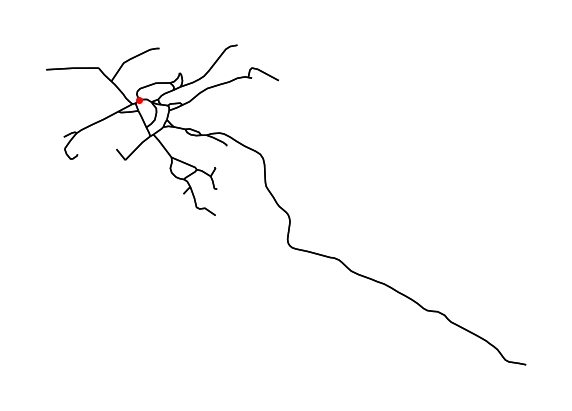

In [9]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



# get network from place name 

city = ox.graph.graph_from_place('Vandoncourt',network_type='drive')


# eulerize and get circuit

city_eulerized = nx.eulerize(city.to_undirected())
circuit = list(nx.eulerian_circuit(city_eulerized))


# get coordinates of path 

original_nodes,original_edges = ox.graph_to_gdfs(city)
origin_node = original_nodes.iloc[0]
origin = list(origin_node['geometry'].coords)

index = original_edges.index
lon_lat_path = origin
step_dic = {edge:0 for edge in circuit}

for edge in circuit:
    is_edge = [set(edge).issubset(i) for i in index]    
    gdf_edges = original_edges[is_edge]
    n_edges = len(gdf_edges)
    geom = gdf_edges['geometry']    
    step = step_dic[edge]
    coords = list(geom.iloc[step].coords)

    if lon_lat_path[-1] == coords[0]:
        lon_lat_path.extend(coords)

    else:
        lon_lat_path.extend(coords[::-1])
        
    if n_edges > 1:
        step_dic[edge] = (step + 1) % n_edges

        
# create gif

bg_edges = ox.graph_to_gdfs(city,nodes=False)
bg_edges = ox.project_gdf(bg_edges)

points = [Point(x,y) for x,y in lon_lat_path]
series = gpd.GeoSeries(points)

gdf = gpd.GeoDataFrame(geometry=series)
gdf = gdf.set_crs('EPSG:4326')
gdf = ox.project_gdf(gdf)

x,y = gdf['geometry'].x,gdf['geometry'].y

fig,ax = plt.subplots(figsize=(10,10))
bg_edges.plot(ax=ax,color='black')

ax.axis('off')
    
p = 200
ax.set_xlim([min(x)-p,max(x)+p])
ax.set_ylim([min(y)-p,max(y)+p])

point, = ax.plot([],[],'ro',ls='none')

def animate(k): # you can probably remove every other frame
    i = min(k,len(x))
    point.set_data(x[i],y[i])
    return(point)

animation = FuncAnimation(fig=fig,func=animate,frames=len(x),interval=50)
animation.save(filename="./animation.gif",dpi=80,fps=30)